In [1]:
!pip install gymnasium[mujoco] mujoco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 28.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import h5py
import urllib.request
import os
import gymnasium as gym
import warnings

# ==========================================
# 0. A100 SPECIFIC SETUP
# ==========================================
# Enable TF32 for significantly faster matrix math on Ampere (A100) GPUs
torch.set_float32_matmul_precision('high')

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


CONF = {
    'env_name': 'Hopper-v5',
    'context_length': 20,
    'embed_dim': 512,
    'n_layer': 4,
    'n_head': 4,
    'activation': 'relu',
    'dropout': 0.1,

    'batch_size': 4096,        # Huge Batch
    'max_train_steps': 2500,
    'warmup_steps': 250,
    'lr': 6e-4,
    'weight_decay': 1e-4,
    'eval_interval': 100,      # Evaluate every 500 steps
    'device': 'cuda'
}

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [3]:


# ==========================================
# 1. GPU-RESIDENT DATASET
# ==========================================
class GPUDataset:
    def __init__(self, context_length, data_dir='./data', scale=1000., device='cuda'):
        self.context_length = context_length
        self.scale = scale
        if not os.path.exists(data_dir): os.makedirs(data_dir)

        file_name = "hopper_medium.hdf5"
        file_path = os.path.join(data_dir, file_name)
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            urllib.request.urlretrieve("http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/hopper_medium.hdf5", file_path)

        with h5py.File(file_path, 'r') as f:
            obs = f['observations'][:].astype(np.float32)
            act = f['actions'][:].astype(np.float32)
            rew = f['rewards'][:].astype(np.float32)
            term = f['terminals'][:]

        # Repair Boundaries
        episode_starts, cur_len = [0], 0
        rtg_raw = np.zeros_like(rew)
        for i in range(len(rew)):
            cur_len += 1
            if term[i] or cur_len >= 1000:
                start = episode_starts[-1]
                rtg_raw[start:i+1] = np.cumsum(rew[start:i+1][::-1])[::-1] / scale
                if i + 1 < len(rew):
                    episode_starts.append(i + 1)
                    cur_len = 0

        # Normalize
        obs_mean = obs.mean(axis=0)
        obs_std = obs.std(axis=0) + 1e-6
        obs = (obs - obs_mean) / obs_std

        print("Moving dataset to GPU VRAM (Forcing Float32)...")
        # --- FIX: Explicitly cast to float32 to prevent Double vs Float error ---
        self.obs = torch.from_numpy(obs).to(dtype=torch.float32, device=device)
        self.act = torch.from_numpy(act).to(dtype=torch.float32, device=device)
        self.rtg = torch.from_numpy(rtg_raw).to(dtype=torch.float32, device=device).unsqueeze(-1)

        self.timesteps = torch.zeros(len(rew), dtype=torch.long, device=device)
        for i in range(len(episode_starts)):
            s = episode_starts[i]
            e = episode_starts[i+1] if i+1 < len(episode_starts) else len(rew)
            self.timesteps[s:e] = torch.arange(e - s, device=device)

        self.episode_starts = episode_starts
        self.state_mean = torch.from_numpy(obs_mean).to(dtype=torch.float32, device=device)
        self.state_std = torch.from_numpy(obs_std).to(dtype=torch.float32, device=device)
        self.act_dim = act.shape[1]
        self.state_dim = obs.shape[1]

    def get_batch(self, batch_size):
        # Fast random sampling on GPU
        ix = torch.randint(0, len(self.obs) - self.context_length, (batch_size,), device=self.obs.device)

        ctx_idxs = ix.unsqueeze(1) + torch.arange(self.context_length, device=self.obs.device)

        s = self.obs[ctx_idxs]
        a = self.act[ctx_idxs]
        r = self.rtg[ctx_idxs]
        t = self.timesteps[ctx_idxs]

        # Simple boundary masking
        expected = t[:, :1] + torch.arange(self.context_length, device=self.obs.device)
        mask = (t == expected).float()

        return s, a, r, t, mask

# ==========================================
# 2. COMPILED MODEL
# ==========================================
class DecisionTransformer(nn.Module):
    def __init__(self, state_dim, act_dim, hidden_size, max_length=20, max_ep_len=1000, n_layer=4, n_head=4):
        super().__init__()
        self.embed_timestep = nn.Embedding(max_ep_len + 1, hidden_size)
        self.embed_return = nn.Linear(1, hidden_size)
        self.embed_state = nn.Linear(state_dim, hidden_size)
        self.embed_action = nn.Linear(act_dim, hidden_size)
        self.embed_ln = nn.LayerNorm(hidden_size)

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_size, nhead=n_head, dim_feedforward=4*hidden_size,
                dropout=0.1, activation='relu', batch_first=True, norm_first=True
            ), num_layers=n_layer
        )
        self.predict_action = nn.Sequential(nn.Linear(hidden_size, act_dim), nn.Tanh())

    def forward(self, states, actions, returns, timesteps):
        B, T, _ = states.shape
        time_emb = self.embed_timestep(timesteps)
        s_emb = self.embed_state(states) + time_emb
        a_emb = self.embed_action(actions) + time_emb
        r_emb = self.embed_return(returns) + time_emb

        stacked = torch.stack((r_emb, s_emb, a_emb), dim=2).reshape(B, 3*T, -1)
        stacked = self.embed_ln(stacked)
        mask = torch.triu(torch.full((3*T, 3*T), float('-inf'), device=states.device), 1)

        x = self.transformer(stacked, mask=mask, is_causal=True)
        x = x.reshape(B, T, 3, -1)
        return self.predict_action(x[:, :, 1, :])


def evaluate(model, dataset, target=3600):
    model.eval()
    try: env = gym.make("Hopper-v4")
    except: env = gym.make("Hopper-v5")

    state, _ = env.reset()
    device = CONF['device']

    # --- FIX: Ensure Eval Inputs are Float32 ---
    states = ((torch.from_numpy(state).float().to(device) - dataset.state_mean) / dataset.state_std).reshape(1, 1, -1)
    actions = torch.zeros((1, 1, dataset.act_dim), device=device)
    rtg = torch.tensor([[[target/1000.]]], dtype=torch.float32, device=device)
    timesteps = torch.zeros((1, 1), dtype=torch.long, device=device)

    total_rew = 0
    for t in range(1000):
        with torch.no_grad():
            preds = model(states[:, -20:], actions[:, -20:], rtg[:, -20:], timesteps[:, -20:])
            action = preds[0, -1].cpu().numpy()

        next_state, reward, term, trunc, _ = env.step(action)
        total_rew += reward

        new_s = ((torch.from_numpy(next_state).float().to(device) - dataset.state_mean) / dataset.state_std).reshape(1, 1, -1)
        new_a = torch.from_numpy(action).float().to(device).reshape(1, 1, -1)
        # --- FIX: Ensure RTG calculation stays Float32 ---
        val = rtg[0,-1,0].item() - (reward/1000.)
        new_r = torch.tensor([[[val]]], dtype=torch.float32, device=device)
        new_t = torch.tensor([[t+1]], device=device).reshape(1,1)

        states = torch.cat([states, new_s], dim=1)
        actions = torch.cat([actions, new_a], dim=1)
        rtg = torch.cat([rtg, new_r], dim=1)
        timesteps = torch.cat([timesteps, new_t], dim=1)
        if term or trunc: break

    return 100 * total_rew / 3234.3


In [20]:
def train_lightspeed(conf):
    # Re-use existing classes if available, or re-init
    dataset = GPUDataset(conf['context_length'], device=conf['device'])
    model = DecisionTransformer(
        dataset.state_dim, dataset.act_dim, conf['embed_dim'], n_layer=conf['n_layer'], n_head=conf['n_head']
    ).to(conf['device'])

    print("Compiling model... (Wait ~30s for the first step)")
    model = torch.compile(model)

    optimizer = optim.AdamW(model.parameters(), lr=conf['lr'], weight_decay=conf['weight_decay'])
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda s: min((s+1)/conf['warmup_steps'], 1))
    scaler = torch.amp.GradScaler('cuda')

    best_score = 0
    model.train()

    import time
    start_time = time.time()

    for step in range(1, conf['max_train_steps'] + 1):
        # 1. Get Batch (Instant GPU Slice)
        s, a, r, t, mask = dataset.get_batch(conf['batch_size'])

        # 2. Forward & Backward (Ampere Optimized)
        with torch.amp.autocast('cuda'):
            preds = model(s, a, r, t)
            # Flatten
            loss = torch.mean((preds.reshape(-1, dataset.act_dim)[mask.reshape(-1)>0] -
                               a.reshape(-1, dataset.act_dim)[mask.reshape(-1)>0]) ** 2)

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Logging
        if step % 100 == 0:
            elapsed = time.time() - start_time
            sps = step / elapsed
            print(f"Step {step}/{conf['max_train_steps']} | Loss: {loss.item():.4f} | Speed: {sps:.1f} steps/sec")

        # Evaluation
        if step % conf['eval_interval'] == 0:
            print(f"--> Evaluating...")
            score = evaluate(model, dataset, target=3600)
            print(f"    Score: {score:.2f}")
            if score > best_score:
                best_score = score
                torch.save(model.state_dict(), 'best_dt_a100.pt')
            model.train()

    return model, dataset

# RUN NOW
print("Starting Lightspeed Training...")
model, dataset = train_lightspeed(CONF)

Starting Lightspeed Training...
Moving dataset to GPU VRAM (Forcing Float32)...
Compiling model... (Wait ~30s for the first step)
Step 100/2500 | Loss: 0.1561 | Speed: 5.6 steps/sec
--> Evaluating...


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


    Score: 0.56
Step 200/2500 | Loss: 0.1015 | Speed: 5.2 steps/sec
--> Evaluating...


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


    Score: 53.98
Step 300/2500 | Loss: 0.0779 | Speed: 5.1 steps/sec
--> Evaluating...
    Score: 0.89
Step 400/2500 | Loss: 0.0691 | Speed: 5.3 steps/sec
--> Evaluating...
    Score: 44.99
Step 500/2500 | Loss: 0.0605 | Speed: 5.3 steps/sec
--> Evaluating...
    Score: 30.17
Step 600/2500 | Loss: 0.0593 | Speed: 5.3 steps/sec
--> Evaluating...
    Score: 30.26
Step 700/2500 | Loss: 0.0567 | Speed: 5.3 steps/sec
--> Evaluating...
    Score: 31.81
Step 800/2500 | Loss: 0.0557 | Speed: 5.3 steps/sec
--> Evaluating...
    Score: 0.99
Step 900/2500 | Loss: 0.0522 | Speed: 5.4 steps/sec
--> Evaluating...
    Score: 29.69
Step 1000/2500 | Loss: 0.0534 | Speed: 5.4 steps/sec
--> Evaluating...
    Score: 30.93
Step 1100/2500 | Loss: 0.0514 | Speed: 5.4 steps/sec
--> Evaluating...
    Score: 43.42
Step 1200/2500 | Loss: 0.0503 | Speed: 5.4 steps/sec
--> Evaluating...
    Score: 31.17
Step 1300/2500 | Loss: 0.0497 | Speed: 5.4 steps/sec
--> Evaluating...
    Score: 30.28
Step 1400/2500 | Loss: 0

Starting Training with Plotting...
Moving dataset to GPU VRAM (Forcing Float32)...
Step 100/2500 | Loss: 0.1712 | Speed: 2.4 steps/sec
--> Evaluating...


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


    Score: 0.51
Step 200/2500 | Loss: 0.1078 | Speed: 2.6 steps/sec
--> Evaluating...


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


    Score: 26.88
Step 300/2500 | Loss: 0.0763 | Speed: 3.0 steps/sec
--> Evaluating...
    Score: 1.01


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Step 400/2500 | Loss: 0.0656 | Speed: 3.5 steps/sec
--> Evaluating...
    Score: 89.39
Step 500/2500 | Loss: 0.0605 | Speed: 3.7 steps/sec
--> Evaluating...
    Score: 65.24
Step 600/2500 | Loss: 0.0583 | Speed: 3.9 steps/sec
--> Evaluating...
    Score: 98.27
Step 700/2500 | Loss: 0.0558 | Speed: 4.0 steps/sec
--> Evaluating...
    Score: 30.80
Step 800/2500 | Loss: 0.0553 | Speed: 4.1 steps/sec
--> Evaluating...
    Score: 30.71
Step 900/2500 | Loss: 0.0547 | Speed: 4.2 steps/sec
--> Evaluating...
    Score: 99.27
Step 1000/2500 | Loss: 0.0526 | Speed: 4.3 steps/sec
--> Evaluating...
    Score: 44.97
Step 1100/2500 | Loss: 0.0516 | Speed: 4.4 steps/sec
--> Evaluating...
    Score: 85.90
Step 1200/2500 | Loss: 0.0510 | Speed: 4.4 steps/sec
--> Evaluating...
    Score: 29.71
Step 1300/2500 | Loss: 0.0504 | Speed: 4.5 steps/sec
--> Evaluating...
    Score: 30.36
Step 1400/2500 | Loss: 0.0495 | Speed: 4.5 steps/sec
--> Evaluating...
    Score: 89.18
Step 1500/2500 | Loss: 0.0488 | Speed:

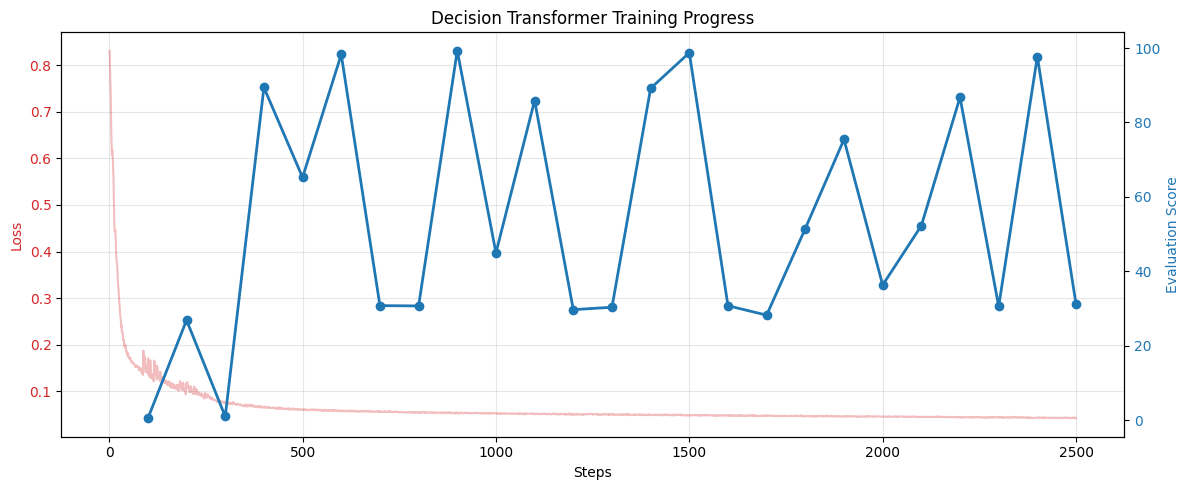

OptimizedModule(
  (_orig_mod): DecisionTransformer(
    (embed_timestep): Embedding(1001, 512)
    (embed_return): Linear(in_features=1, out_features=512, bias=True)
    (embed_state): Linear(in_features=11, out_features=512, bias=True)
    (embed_action): Linear(in_features=3, out_features=512, bias=True)
    (embed_ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      

In [4]:
import matplotlib.pyplot as plt
import time

def train_and_plot(conf, dataset):
    # Initialize Model
    model = DecisionTransformer(
        dataset.state_dim, dataset.act_dim, conf['embed_dim'], n_layer=conf['n_layer'], n_head=conf['n_head']
    ).to(conf['device'])

    model = torch.compile(model)

    optimizer = optim.AdamW(model.parameters(), lr=conf['lr'], weight_decay=conf['weight_decay'])
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda s: min((s+1)/conf['warmup_steps'], 1))
    scaler = torch.amp.GradScaler('cuda')

    # Tracking
    steps_log = []
    losses_log = []
    eval_steps = []
    eval_scores = []

    model.train()
    start_time = time.time()

    for step in range(1, conf['max_train_steps'] + 1):
        # 1. Get Batch
        s, a, r, t, mask = dataset.get_batch(conf['batch_size'])

        # 2. Forward & Backward
        with torch.amp.autocast('cuda'):
            preds = model(s, a, r, t)
            loss = torch.mean((preds.reshape(-1, dataset.act_dim)[mask.reshape(-1)>0] -
                               a.reshape(-1, dataset.act_dim)[mask.reshape(-1)>0]) ** 2)

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Logging
        steps_log.append(step)
        losses_log.append(loss.item())

        if step % 100 == 0:
            elapsed = time.time() - start_time
            sps = step / elapsed
            print(f"Step {step}/{conf['max_train_steps']} | Loss: {loss.item():.4f} | Speed: {sps:.1f} steps/sec")

        # Evaluation
        if step % conf['eval_interval'] == 0:
            print(f"--> Evaluating...")
            score = evaluate(model, dataset, target=3600)
            print(f"    Score: {score:.2f}")
            eval_steps.append(step)
            eval_scores.append(score)
            model.train()

    # Plotting
    fig, ax1 = plt.subplots(figsize=(12, 5))

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(steps_log, losses_log, color='tab:red', alpha=0.3, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Evaluation Score', color='tab:blue')
    ax2.plot(eval_steps, eval_scores, color='tab:blue', marker='o', linewidth=2, label='Eval Score')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Decision Transformer Training Progress')
    fig.tight_layout()
    plt.show()

    return model

# Reuse the existing dataset to save time
print("Starting Training with Plotting...")
if 'dataset' not in globals():
    dataset = GPUDataset(CONF['context_length'], device=CONF['device'])
train_and_plot(CONF, dataset)

In [22]:
# Final Eval
print("\nFinal Evaluation...")
model.load_state_dict(torch.load('best_dt_a100.pt'))
model.eval()
scores = [evaluate(model, dataset, target=3600) for _ in range(20)]
print(f"Final Score: {np.mean(scores):.2f} ± {np.std(scores):.2f}")


Final Evaluation...
Final Score: 80.63 ± 25.94


In [23]:
# Final Eval
print("\nFinal Evaluation...")
model.load_state_dict(torch.load('best_dt_a100.pt'))
model.eval()
scores = [evaluate(model, dataset, target=1800) for _ in range(20)]
print(f"Final Score: {np.mean(scores):.2f} ± {np.std(scores):.2f}")


Final Evaluation...
Final Score: 55.38 ± 12.97


In [24]:
# Final Eval
print("\nFinal Evaluation...")
model.load_state_dict(torch.load('best_dt_a100.pt'))
model.eval()
scores = [evaluate(model, dataset, target=400) for _ in range(20)]
print(f"Final Score: {np.mean(scores):.2f} ± {np.std(scores):.2f}")


Final Evaluation...
Final Score: 26.71 ± 0.26
